In [1]:
import os
import glob
import itertools
import time

import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt

from scegot import scEGOT
import wot

# scEGOT

In [2]:
DATASET_INPUT_ROOT_PATH = "../data/"
ANNDATA_DATASET_PATH = os.path.join(
    DATASET_INPUT_ROOT_PATH, "scRNAseq_hPGCLC_induction_Saitou.h5ad"
)
# CSV_DATASET_FOLDER_PATH = os.path.join(DATASET_INPUT_ROOT_PATH, "csv_folder/")
RANDOM_STATE = 2023
PCA_N_COMPONENTS = 150
GMM_CLUSTER_NUMBERS = [1, 2, 4, 5, 5]
UMAP_N_NEIGHBORS = 1000
DAY_NAMES = ["day0", "day0.5", "day1", "day1.5", "day2"]

In [3]:
# ----- In the case of AnnData -----
input_data = anndata.read_h5ad(ANNDATA_DATASET_PATH)
print(input_data)
display(input_data.X)
display(input_data.obs)
display(input_data.var)

# ----- In the case of DataFrame (CSV) -----
# input_file_paths = sorted(glob.glob(f"{CSV_DATASET_FOLDER_PATH}*.csv"))
# input_data = [
#     pd.read_csv(input_file_path, index_col=0) for input_file_path in input_file_paths
# ]
# print(f"number of days: {len(input_data)}")
# print("shape of each day's data:")
# for i, data in enumerate(input_data):
#     print(f"    {DAY_NAMES[i]}: {data.shape}")
# print("data example: ")
# input_data[0].head()

AnnData object with n_obs × n_vars = 11771 × 18922
    obs: 'sample', 'percent.mito', 'day', 'cluster_day'
    var: 'spliced', 'unspliced', 'mt', 'TF', 'gene_name'
    layers: 'X_raw', 'spliced', 'unspliced'


<11771x18922 sparse matrix of type '<class 'numpy.float32'>'
	with 94477374 stored elements in Compressed Sparse Row format>

,sample,percent.mito,day,cluster_day
iM.data_GTGGAAGGTCAATGGG-1,iM.data,0.056487,iM,day0
iM.data_TTCATGTCAACCCGCA-1,iM.data,0.216231,iM,day0
iM.data_GAGGGTATCCAGGACC-1,iM.data,0.076525,iM,day0
iM.data_AAGTCGTAGGCTTTCA-1,iM.data,0.080264,iM,day0
iM.data_ACCGTTCGTAACTTCG-1,iM.data,0.280788,iM,day0
...,...,...,...,...
d2b.data_AAGCCATAGGGCGAGA-1,d2b.data,4.811476,d2b,day2
d2b.data_CAACCAATCTTCCGTG-1,d2b.data,2.554428,d2b,day2
d2b.data_AGGCCACGTGAGTAGC-1,d2b.data,3.142146,d2b,day2
d2b.data_GATCAGTTCGAGTACT-1,d2b.data,4.287140,d2b,day2


,spliced,unspliced,mt,TF,gene_name
FAM3A,1,1,0,0,FAM3A
SLC25A1,1,1,0,0,SLC25A1
RBL1,1,1,0,0,RBL1
PPP2R1A,1,1,0,0,PPP2R1A
H3F3B,1,1,0,0,H3F3B
...,...,...,...,...,...
OR2W5,1,0,0,0,OR2W5
ODF4,1,1,0,0,ODF4
CRP,1,0,0,0,CRP
KRTAP4-9,1,0,0,0,KRTAP4-9


In [4]:
# ----- In the case of AnnData -----
scegot = scEGOT(
    input_data,
    verbose=True,  # default=True
    adata_day_key="cluster_day",
)

# ----- In the case of DataFrame (CSV) -----
# scegot = scEGOT(
#     input_data,
#     verbose=True,  # default=True
#     day_names=DAY_NAMES, # uncomment this line if you use an array of DataFrames
# )

Processing AnnData...


In [5]:
%%time
X, pca_model = scegot.preprocess(
    PCA_N_COMPONENTS,
    recode_params={},
    umi_target_sum=1e5,
    pca_random_state=RANDOM_STATE,
    pca_other_params={},
    apply_recode=True,
    apply_normalization_log1p=True,
    apply_normalization_umi=True,
    select_genes=True,
    n_select_genes=2000,
)

Applying RECODE...
start RECODE for scRNA-seq data
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 15820, '#non-significant genes': 2582, '#silent genes': 65, 'ell': 288, 'Elapsed time': '0h 0m 22s 061ms', 'solver': 'randomized', '#test_data': 2354}
Applying UMI normalization...
Applying log1p normalization...
Applying PCA...
	sum of explained_variance_ratio = 93.67122272048897
CPU times: user 1min 39s, sys: 17 s, total: 1min 56s
Wall time: 31.9 s


In [6]:
%%time
gmm_models, gmm_labels = scegot.fit_predict_gmm(
    n_components_list=GMM_CLUSTER_NUMBERS,
    covariance_type="full",
    max_iter=2000,
    n_init=10,
    random_state=RANDOM_STATE,
    gmm_other_params={},
)

Fitting GMM models with each day's data and predicting labels for them...


100%|██████████| 5/5 [00:17<00:00,  3.51s/it]

CPU times: user 1min 25s, sys: 1min 15s, total: 2min 41s
Wall time: 17.7 s


In [7]:
%%time
scegot_ot_times = []
for i in range(len(scegot.day_names) - 1):
    start_time = time.time()
    scegot.calculate_solution(
        scegot.gmm_models[i],
        scegot.gmm_models[i + 1],
    )
    end_time = time.time()
    scegot_ot_times.append(end_time - start_time)

CPU times: user 9.76 s, sys: 1.03 s, total: 10.8 s
Wall time: 1.15 s


# WOT

In [8]:
FLE_COORDS_PATH = "../data/wot/fle_coords.txt"
FULL_DS_PATH = "../data/wot/ExprMatrix.h5ad"
# VAR_DS_PATH = 'data/ExprMatrix.var.genes.h5ad'
CELL_DAYS_PATH = "../data/wot/cell_days.txt"
GENE_SETS_PATH = "../data/wot/gene_sets.gmx"
GENE_SET_SCORES_PATH = "output/gene_set_scores.csv"
CELL_SETS_PATH = "../data/wot/cell_sets.pkl"  

In [9]:
coord_df = pd.read_csv(FLE_COORDS_PATH, index_col="id", sep="\t")
days_df = pd.read_csv(CELL_DAYS_PATH, index_col="id", sep="\t")

# Read expression matrix, cell days, and 2-d coordinates
adata = wot.io.read_dataset(FULL_DS_PATH, obs=[days_df, coord_df])

In [10]:
os.makedirs("output", exist_ok=True)

In [11]:
gs = wot.io.read_sets(GENE_SETS_PATH, adata.var.index.values)
gene_set_scores_df = pd.DataFrame(index=adata.obs.index)
for j in range(gs.shape[1]):
    gene_set_name = str(gs.var.index.values[j])
    result = wot.score_gene_sets(
        ds=adata, gs=gs[:, [j]], permutations=0, method="mean_z_score"
    )
    gene_set_scores_df[gene_set_name] = result["score"]
gene_set_scores_df.to_csv(GENE_SET_SCORES_PATH, index_label="id")

In [12]:
# load proliferation and apoptosis scores
gene_set_scores = pd.read_csv("output/gene_set_scores.csv", index_col=0)
proliferation = gene_set_scores["Cell.cycle"]
apoptosis = gene_set_scores["Apoptosis"]


# apply logistic function to transform to birth rate and death rate
def logistic(x, L, k, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f


def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)


def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)


def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center, width=0.2)


birth = beta(proliferation)
death = delta(apoptosis)

# growth rate is given by
gr = np.exp(birth - death)
growth_rates_df = pd.DataFrame(
    index=gene_set_scores.index, data={"cell_growth_rate": gr}
)
growth_rates_df.to_csv("output/growth_gs_init.txt")

In [13]:
VAR_GENE_DS_PATH = "../data/wot/ExprMatrix.var.genes.h5ad"
SERUM_CELL_IDS_PATH = "../data/wot/pgclc_cell_ids.txt"
CELL_GROWTH_PATH = "output/growth_gs_init.txt"

# load data
adata = wot.io.read_dataset(
    VAR_GENE_DS_PATH,
    obs=[CELL_DAYS_PATH, CELL_GROWTH_PATH],
    obs_filter=SERUM_CELL_IDS_PATH,
)
adata.shape

(7208, 2000)

In [14]:
ot_model = wot.ot.OTModel(
    adata,
    local_pca=PCA_N_COMPONENTS,
    solver="fixed_iters",
    epsilon=0.01,
    lambda1=1,
    lambda2=50,
    tau=1e8,
    inner_iter_max=1e10,
    growth_iters=3,
)
day_names_float = [0, 0.5, 1, 1.5, 2]

In [15]:
%%time
wot_ot_times = []
for i in range(len(day_names_float) - 1):
    start_time = time.time()
    tmap_annotated = ot_model.compute_transport_map(
        day_names_float[i], day_names_float[i + 1]
    )
    end_time = time.time()
    wot_ot_times.append(end_time - start_time)

CPU times: user 25min 46s, sys: 5min 54s, total: 31min 41s
Wall time: 3min 26s


# TrajectoryNet

In [ ]:
# %%time
# start_time = time.time()
# !python -m TrajectoryNet.main \
#     --dataset ../trajectorynet/output/pgclc_150dim.npz \
#     --embedding_name "original_embedding_150d" \
#     --save results/pgclc
# end_time = time.time()
# trajectorynet_time = end_time - start_time

True
/opt/anaconda3/lib/python3.11/site-packages/TrajectoryNet/main.py
""" main.py

Learns ODE from scrna data

"""
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from TrajectoryNet.lib.growth_net import GrowthNet
from TrajectoryNet.lib import utils
from TrajectoryNet.lib.visualize_flow import visualize_transform
from TrajectoryNet.lib.viz_scrna import (
    save_trajectory,
    trajectory_to_video,
    save_vectors,
)
from TrajectoryNet.lib.viz_scrna import save_trajectory_density


# from train_misc import standard_normal_logprob
from TrajectoryNet.train_misc import (
    set_cnf_options,
    count_nfe,
    count_parameters,
    count_total_time,
    add_spectral_norm,
    spectral_norm_power_iteration,
    create_regularization_fns,
    get_regularization,
    append_regularization_to_log,
    build_model_tabular,
)

from TrajectoryNet import dataset
from Trajectory

# Comparing figures


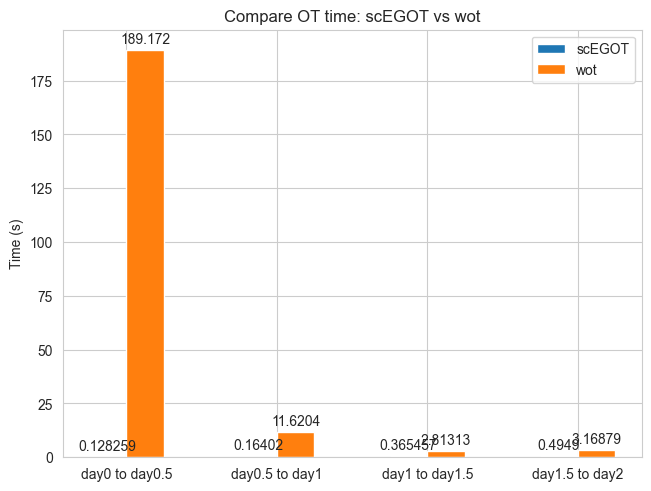

In [24]:
x = np.arange(len(scegot_ot_times))
width = 0.25

fig, ax = plt.subplots(layout="constrained")

offset = 0
rects = ax.bar(x + offset, scegot_ot_times, width, label="scEGOT")
ax.bar_label(rects, padding=3)

offset += width
rects = ax.bar(x + offset, wot_ot_times, width, label="wot")
ax.bar_label(rects, padding=3)

ax.set_ylabel("Time (s)")
ax.set_title("Compare OT time: scEGOT vs wot")
ax.legend()
ax.set_xticks(
    x + width / 2,
    labels=[
        f"{scegot.day_names[i]} to {scegot.day_names[i+1]}"
        for i in range(len(scegot.day_names) - 1)
    ],
)
fig.savefig("../figure/compare_ot_time.jpeg", format="jpeg", dpi=300, bbox_inches="tight")

NameError: name 'trajectorynet_time' is not defined

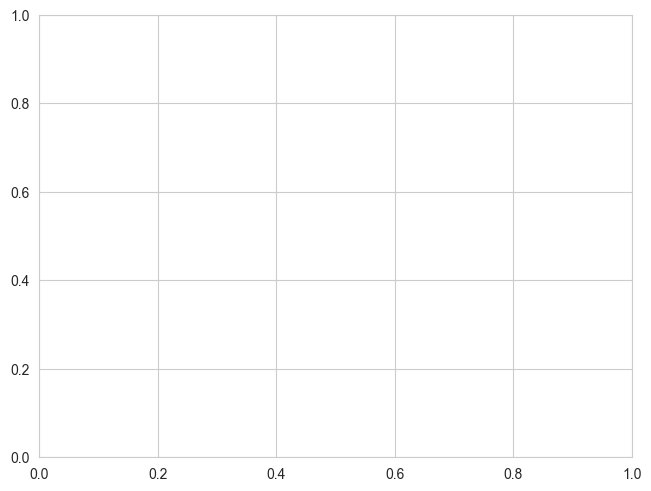

In [25]:
# fig, ax = plt.subplots(layout="constrained")
# ax.bar(
#     ["scEGOT", "wot", "TrajectoryNet"],
#     [sum(scegot_ot_times), sum(wot_ot_times), trajectorynet_time],
# )
# ax.set_ylabel("Total time (s)")

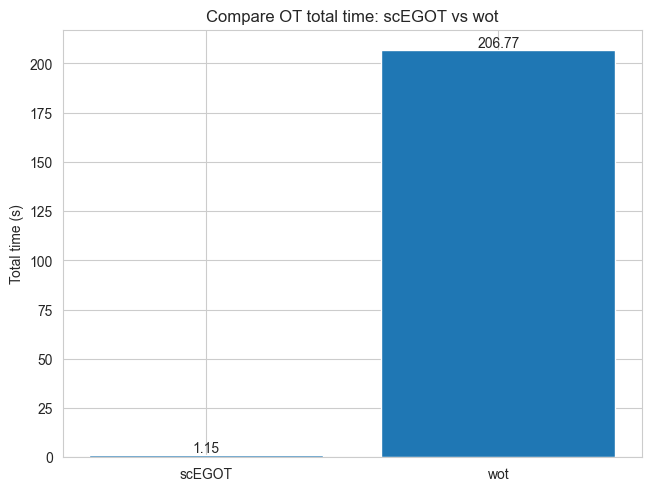

In [26]:
fig, ax = plt.subplots(layout="constrained")
rects = ax.bar(
    ["scEGOT", "wot"],
    [sum(scegot_ot_times), sum(wot_ot_times)],
)
for bar in rects:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', va='bottom', ha='center')
ax.set_ylabel("Total time (s)")
ax.set_title("Compare OT total time: scEGOT vs wot")
fig.savefig("../figure/compare_ot_total_time.jpeg", format="jpeg", dpi=300, bbox_inches="tight")